## Set variables

In [36]:
dataset_path = './data/gtzan'
diraudiofiles = f"{dataset_path}/genres_3sec"
features_path = f'{dataset_path}/features'
melspec_path = f'{features_path}/melspecs_3sec'
test_dir = f'{dataset_path}/test1'

In [37]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

In [53]:
# model_name_or_path = "m3hrdadfi/wav2vec2-base-100k-gtzan-music-genres"
model_name_or_path = "models/wav2vec2-base-100k-voxpopuli-gtzan-music/checkpoint-7900/"

## Genre classifier using wav2wec2 

In [39]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput

@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

In [40]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


## Use pretrained wav2vec2 model to predict genre

We are using a pretrained model uploaded to Huggingface. Maybe we should train a model ourselves?

In [41]:
from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_name_or_path)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
sampling_rate = feature_extractor.sampling_rate

In [43]:
feature_extractor

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [44]:
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

## Predict genres of manually curated songs

These audiofiles are preprocessed to be of the same properties as the GTZAN dataset, i.e.,

- sampling rate = 22050
- no of channels = 1

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from transformers import AutoConfig, Wav2Vec2Processor

import librosa
import numpy as np
import pandas as pd

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_name_or_path)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
sampling_rate = feature_extractor.sampling_rate
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

In [47]:
def speech_file_to_array_fn(path, sampling_rate):
    speech_array, _sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech


def predict(path, sampling_rate):
    speech = speech_file_to_array_fn(path, sampling_rate)
    features = feature_extractor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)

    with torch.no_grad():
        logits = model(input_values).logits

    scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    outputs = [{"Label": config.id2label[i], "Score": f"{round(score * 100, 3):.1f}%"} for i, score in enumerate(scores)]
    return scores

In [48]:
test_dir = f'{dataset_path}/genres_test'
songs = 'Taylor_Swift_Love_Story'
songs += ' Nirvana_Smells_Like_Teen_Spirit'
songs += ' Green_Day_American_Idiot'
songs = songs.split()

In [49]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [50]:
preds = None

for song in tqdm(songs):
    path = f'{test_dir}/{song}.wav'
    scores = predict(path, sampling_rate)

    if preds is None:
        preds = scores
    else:
        preds = np.vstack([preds, scores])

  0%|          | 0/3 [00:00<?, ?it/s]

In [51]:
preds[0]

array([2.4891639e-05, 8.6095468e-05, 2.9740477e-04, 1.4704482e-03,
       1.8970914e-04, 6.0617047e-05, 7.2981500e-05, 9.9767405e-01,
       6.5529777e-05, 5.8331821e-05], dtype=float32)

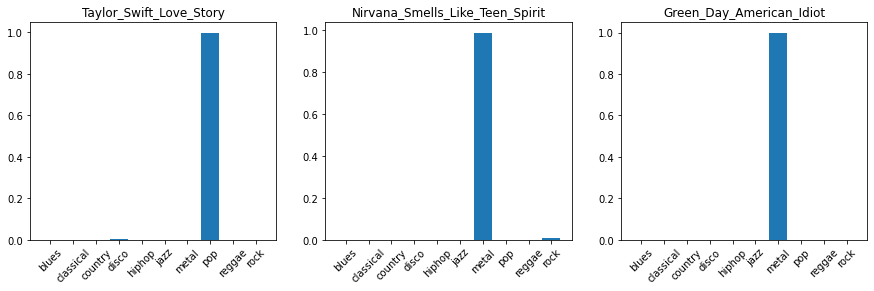

In [52]:
fig,ax = plt.subplots(1,len(songs),figsize=(15,4))

for i in range(len(songs)):
    ax[i].bar(x=genres,height=preds[i])
    ax[i].tick_params('x', labelrotation=45)
    ax[i].set_title(f'{songs[i]}')
    
plt.show()